# Coursera Capstone Project

## Segmenting and Clustering Toronto Neighborhoods

### 1. Importing libraries and data

In [83]:
# Import pandas and numpy libraries
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import urllib3

#KMeans for clustering
from sklearn.cluster import KMeans

#MinmaxScaler for normalizing data before clustering
from sklearn.preprocessing import MinMaxScaler

#folium library to draw maps
import folium

#Requests for Foursquare API querying
import requests

# import geocoder
!conda install -c conda-forge geocoder           
import geocoder 

#import plotting library
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm


Solving environment: ...working... done

# All requested packages already installed.



In [84]:
    #Canada demographic data
    can_demo="https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv"

In [85]:
# Foursquare API Developer Credentials
CLIENT_ID = 'ULY1JHPY2V3KKER1IMANQMJ3WTLSBK0Z3DY0OR0UNQCKOOF4' # Foursqaure ID
CLIENT_SECRET = 'BI5E2JPNLMYWVGH0OWAGXFIT253LFJDFRSWN42GGCMIT4XLD' # Foursquare Secret
VERSION = '20180605' # The Foursquare API version

In [86]:
# Define constants for venue search in Foursquare API
radius = 500
LIMIT = 100

In [87]:
#Read the demographic file and convert it into a dataframe 
df_can=pd.read_csv(can_demo,encoding = "cp1252", thousands=',')
df_can.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,...,37,7,137,64,60,94,100,97,27,31
1,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526","27,695",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177","26,918",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


### 2. Data preparation 

In [88]:
#Let us drop the first 5 columns as they are not necessary for our project
df_can_urban=df_can.drop(df_can.columns[[0,1,2,3,4]],axis=1)

#Transpose the dataframe to obtain the Neighborhoods as rows 
df_can_urban=df_can_urban.transpose()

#Reset index
df_can_urban=df_can_urban.reset_index()

#Interchange column positions of Neighborhood names and Neighborhood numbers (columns 'index' and '0')
df_can_urban = df_can_urban.iloc[:, ::-1]

#Drop unnecessary columns to keep only Neighborhood names and Neighborhood numbers (columns 'index' and '0')
df_can_urban.drop(df_can_urban.columns[0:2382], axis=1, inplace=True)

#Rename columns '0' and 'index' as 'CDN' and 'Neighborhood' respectively
df_can_urban.columns=['CDN','Neighborhood']
df_can_urban.head()

,CDN,Neighborhood
0,129,Agincourt North
1,128,Agincourt South-Malvern West
2,20,Alderwood
3,95,Annex
4,42,Banbury-Don Mills


In [89]:
#Create a function to find out the length of each observation
def lengths(str):
    return len(str) - len(str.lstrip())

In [90]:
#Remove the commas in observations
df_demo = df_can.apply(lambda x: x.str.replace(',',''))

#Obtaining data on 'ethnic origin population' and removing the rest of the unwanted data
df_demo = df_demo[df_demo['Topic'] == 'Ethnic origin population']

# Calculate the length of Ethnic origin
df_demo['Length'] = df_demo['Characteristic']

for index, row in df_demo.iterrows():
   
    # The length of Ethnic origin is calculated using the leading spaces in the data
    row['Length'] = lengths(row['Length'])

# Calculate the length of each observation in ethnic origin and retain the ones with higher lengths
df_demo['LengthNew'] = np.where((df_demo['Length'].shift(+1) > df_demo['Length']),"new","")
    
# Reverse the dataframe
df_demo = df_demo.iloc[::-1]

#### Retain the ethnic origins with maximum numbers and drop the rest

In [91]:
# below function can be used to retain the rows with higher values and drop the ones with lower values
df_demo['Retain'] = 0
tempLength = ""

#using for loop 
for index, row in df_demo.iterrows():
    
    # We retain the first observation as we reversed the dataframe and the first row has maximum length
    if tempLength == "":
        df_demo.loc[index, 'Retain'] = 1
        
        # Store the current length in a temporary variable and compare it in the next iteration
        tempLength = row['Length']
    
    else:
        # If the lengths of the previous and current rows are the same, we retain the row 
        if tempLength == row['Length']:
            df_demo.loc[index, 'Retain'] = 1
        
        # New level : we reset the temp variable
        elif row['LengthNew'] == "new":
            
            # reset the temporary variable
            tempLength = ""
            
# the dataframe is reversed
df_demo = df_demo.iloc[::-1]

# Retain the required rows only
df_demo = df_demo[df_demo['Retain'] == 1]

# Drop redundant columns
df_demo = df_demo.drop(['Length', 'LengthNew', 'Retain'], 1)

df_demo.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1348,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,First Nations (North American Indian),27610,25,90,200,345,175,...,60,110,470,355,235,275,90,130,200,85
1349,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Inuit,515,0,0,15,20,10,...,0,0,25,0,0,10,0,0,0,0
1350,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Métis,8465,10,25,100,115,60,...,40,35,110,80,60,80,45,75,40,10
1352,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Acadian,2315,20,0,10,60,0,...,0,0,10,45,20,30,10,0,10,0
1353,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,American,27470,40,70,100,705,325,...,155,145,140,275,95,275,320,280,175,100


In [92]:
#Drop redundant columns
df_demo.drop(df_demo.columns[[0, 1, 2, 4]], axis=1, inplace=True)
df_demo.rename(columns={'Characteristic':''}, inplace=True)

# Make the neighborhood names as the dataframe columns
df_demo = df_demo.transpose()
df_demo.columns = df_demo.iloc[0]
df_demo = df_demo.iloc[1:]

# Drop 'Total' column
df_demo.drop(df_demo.columns[[0]], axis=1, inplace=True)

# Reset the index
df_demo = df_demo.reset_index()

#Rename 'index'as 'Neighborhood'
df_demo.rename(columns={'index':'Neighborhood'}, inplace=True)

df_demo.head()

,Neighborhood,Inuit,Métis,Acadian,American,Canadian,New Brunswicker,Newfoundlander,Nova Scotian,Ontarian,...,Tibetan,Vietnamese,East and Southeast Asian origins; n.i.e.,Other Asian origins; n.i.e.,Fijian,Hawaiian,Maori,Polynesian; n.o.s.,Samoan,Pacific Islands origins; n.i.e.
0,Agincourt North,0,10,20,40,1295,0,10,0,0,...,0,320,20,135,0,0,0,0,0,0
1,Agincourt South-Malvern West,0,25,0,70,1125,0,0,0,0,...,0,180,10,55,0,0,0,0,0,0
2,Alderwood,15,100,10,100,2245,0,15,0,0,...,110,45,0,0,0,0,0,0,0,0
3,Annex,20,115,60,705,4655,0,10,10,0,...,0,145,15,25,0,0,10,0,0,10
4,Banbury-Don Mills,10,60,0,325,3035,0,0,10,0,...,0,115,0,45,0,0,10,0,0,0








### 3. Adding Geographical Coordinates for each Neighborhood


In [93]:
# Function to return latitude and longitude of postal codes
def PostalCodeCoord(postal_code):
    
    # set to None initially
    coord_lat_lng = None

    # using while loop to get coordinates
    while(coord_lat_lng is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        coord_lat_lng = g.latlng

    latitude = coord_lat_lng[0]
    longitude = coord_lat_lng[1]
    
    return latitude, longitude

In [94]:
postalCodeCoord = []

# Looping through each postal code in our dataframe
for neigh in df_can_urban['Neighborhood']:
    # Fill the temporary list with the coordinates from geocoder
    latitude, longitude = PostalCodeCoord(neigh)
    postalCodeCoord.append([neigh, latitude, longitude])
    
# Transform the temp list into a dataframe
df_coords = pd.DataFrame(postalCodeCoord)
df_coords.columns = ['Neighborhood', 'Latitude', 'Longitude']

# Merge the coordinates dataframe with the original neighbourhoods dataframe (key : postal code)
df_can_urban = pd.merge(df_can_urban, df_coords, on='Neighborhood')

df_can_urban.head()

,CDN,Neighborhood,Latitude,Longitude
0,129,Agincourt North,43.80930,-79.26707
1,128,Agincourt South-Malvern West,43.78735,-79.26941
2,20,Alderwood,43.60496,-79.54116
3,95,Annex,43.66936,-79.40280
4,42,Banbury-Don Mills,43.74041,-79.34852


### 4. Clustering the Neighborhoods on Ethnic Origin


####         Create a map of Toronto City

In [95]:
address = 'Toronto, ON'

# set to None initially
coord_lat_lng = None

# use while loop to get the coordinates
while(coord_lat_lng is None):
    g = geocoder.arcgis('Toronto, ON')
    coord_lat_lng = g.latlng

latitude_toronto = coord_lat_lng[0]
longitude_toronto = coord_lat_lng[1]

print('Coordinates of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

Coordinates of Toronto are 43.648690000000045, -79.38543999999996.


In [96]:
# Map of Toronto city
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# Adding markers to the above map
for lat, lng, CDN, neighborhood in zip(df_can_urban['Latitude'], df_can_urban['Longitude'], df_can_urban['CDN'], df_can_urban['Neighborhood']):
    label = '{}-{}'.format(CDN,neighborhood)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto) 
    
map_toronto

#### Print all neighborhoods with the top 10 ethnic origins 

In [97]:
num_top = 10

# Iterate through the whole dataframe
for index, row in df_demo.iterrows():
    Areatemp = row['Neighborhood']
    
    print("----"+Areatemp+"----")
    
    # Create a temporary dataframe filtered on the current neighbourhood (key : City_Area)
    temp = df_demo[
        (df_demo.Neighborhood == Areatemp)
    ].T.reset_index()
    
    temp.columns = ['Origin','Count']

    # We skip the key PostalCode x Borough x Neighbourhood : length = 3, iloc[3:]
    temp = temp.iloc[1:]
    temp['Count'] = temp['Count'].astype(float)
    
    # Round the frequency with two digits
    temp = temp.round({'Count': 2})
    
    print(temp.sort_values('Count', ascending=False).reset_index(drop=True).head(num_top))
    print('\n')

----Agincourt North----
              Origin    Count
0            Chinese  16950.0
1         Sri Lankan   2230.0
2        East Indian   2090.0
3           Filipino   1465.0
4           Canadian   1295.0
5            English    870.0
6              Tamil    855.0
7           Jamaican    780.0
8           Scottish    600.0
9              Irish    425.0


----Agincourt South-Malvern West----
              Origin    Count
0            Chinese  11455.0
1        East Indian   2180.0
2           Filipino   1405.0
3         Sri Lankan   1145.0
4           Canadian   1125.0
5            English    985.0
6           Scottish    725.0
7           Jamaican    645.0
8            Italian    630.0
9              Irish    620.0


----Alderwood----
             Origin   Count
0           English  2320.0
1          Canadian  2245.0
2             Irish  1900.0
3          Scottish  1720.0
4           Italian  1275.0
5            Polish  1225.0
6            German   940.0
7            French   850.0
8    

              Origin   Count
0            English  2540.0
1           Canadian  2355.0
2           Scottish  1925.0
3              Irish  1820.0
4        East Indian  1420.0
5            Chinese   975.0
6            Italian   900.0
7             German   885.0
8           Filipino   855.0
9             French   700.0


----Church-Yonge Corridor----
              Origin   Count
0            English  5255.0
1              Irish  4705.0
2           Scottish  4325.0
3            Chinese  4305.0
4           Canadian  4180.0
5             French  2390.0
6             German  2315.0
7        East Indian  2045.0
8            Italian  1665.0
9             Polish  1530.0


----Clairlea-Birchmount----
              Origin   Count
0           Canadian  4125.0
1           Filipino  3250.0
2            English  2810.0
3            Chinese  2440.0
4        East Indian  2185.0
5              Irish  2115.0
6           Scottish  2010.0
7        Bangladeshi  1390.0
8            Italian  1210.0
9         

            Origin   Count
0          English  4385.0
1            Irish  3860.0
2         Scottish  3730.0
3         Canadian  3345.0
4           German  2265.0
5           Polish  2005.0
6           French  1875.0
7        Ukrainian  1645.0
8          Italian  1320.0
9          Russian  1205.0


----High Park-Swansea----
                                Origin   Count
0                              English  6115.0
1                                Irish  5265.0
2                             Scottish  4970.0
3                             Canadian  3710.0
4                               German  2365.0
5                               Polish  2250.0
6                               French  2135.0
7                              Italian  1785.0
8                            Ukrainian  1760.0
9        British Isles origins; n.i.e.   970.0


----Highland Creek----
              Origin   Count
0        East Indian  2595.0
1         Sri Lankan  1445.0
2            Chinese  1195.0
3           Canad

              Origin   Count
0            English  3325.0
1           Canadian  3050.0
2              Irish  2755.0
3           Scottish  2660.0
4            Chinese  1650.0
5             French  1515.0
6             German  1395.0
7            Italian  1090.0
8        East Indian   855.0
9             Polish   740.0


----Mount Dennis----
                                Origin   Count
0                             Jamaican  1510.0
1                           Portuguese  1465.0
2                             Canadian  1415.0
3                             Filipino   840.0
4                              English   765.0
5                              Italian   670.0
6                           Vietnamese   650.0
7                                Irish   530.0
8        Other African origins; n.i.e.   500.0
9                             Scottish   495.0


----Mount Olive-Silverstone-Jamestown----
                                Origin   Count
0                          East Indian  8540.0
1  

              Origin   Count
0            Chinese  3890.0
1            English  1940.0
2           Canadian  1705.0
3            Iranian  1365.0
4             Polish  1355.0
5              Irish  1255.0
6           Scottish  1240.0
7            Russian  1050.0
8        East Indian   870.0
9             Korean   830.0


----Steeles----
              Origin    Count
0            Chinese  17835.0
1        East Indian   1115.0
2           Canadian    855.0
3           Filipino    675.0
4            English    560.0
5              Greek    430.0
6            Italian    365.0
7           Scottish    335.0
8         Sri Lankan    305.0
9           Egyptian    300.0


----Stonegate-Queensway----
             Origin   Count
0           English  4555.0
1          Canadian  4060.0
2             Irish  4020.0
3          Scottish  3770.0
4            Polish  2900.0
5           Italian  2610.0
6         Ukrainian  2605.0
7            German  1870.0
8            French  1605.0
9        Portuguese  12

#### Sort the data and save it into a dataframe

In [98]:
#Function to sort the venues
def most_common_ethnic(row, num_top):
    
    # Remove the key from the row
    row_categories = row.iloc[1:].astype(float)
    
    # Sort ascending
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # Return the top num_top_venues
    return row_categories_sorted.index.values[0:num_top]

In [99]:
num_top = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top):
    try:
        columns.append('{}{} Most Common Ethnic Origin'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Ethnic Origin'.format(ind+1))

# create a new dataframe, and set it with the columns names
ethn_sorted_areas = pd.DataFrame(columns=columns)

# add the keys from the grouped dataframe (City_Area)
ethn_sorted_areas['Neighborhood'] = df_demo['Neighborhood']

# loop through each rows
for ind in np.arange(df_demo.shape[0]):
    ethn_sorted_areas.iloc[ind, 1:] = most_common_ethnic(df_demo.iloc[ind, :], num_top)

ethn_sorted_areas.head()

,Neighborhood,1st Most Common Ethnic Origin,2nd Most Common Ethnic Origin,3rd Most Common Ethnic Origin,4th Most Common Ethnic Origin,5th Most Common Ethnic Origin,6th Most Common Ethnic Origin,7th Most Common Ethnic Origin,8th Most Common Ethnic Origin,9th Most Common Ethnic Origin,10th Most Common Ethnic Origin
0,Agincourt North,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,Agincourt South-Malvern West,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
2,Alderwood,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
3,Annex,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
4,Banbury-Don Mills,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French


#### Cluster Neighborhoods

In [100]:
neigh_cluster=df_demo.drop('Neighborhood',1)

df=neigh_cluster.astype(float)

df.head()


,Inuit,Métis,Acadian,American,Canadian,New Brunswicker,Newfoundlander,Nova Scotian,Ontarian,Québécois,...,Tibetan,Vietnamese,East and Southeast Asian origins; n.i.e.,Other Asian origins; n.i.e.,Fijian,Hawaiian,Maori,Polynesian; n.o.s.,Samoan,Pacific Islands origins; n.i.e.
0,0.0,10.0,20.0,40.0,1295.0,0.0,10.0,0.0,0.0,0.0,...,0.0,320.0,20.0,135.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,25.0,0.0,70.0,1125.0,0.0,0.0,0.0,0.0,0.0,...,0.0,180.0,10.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15.0,100.0,10.0,100.0,2245.0,0.0,15.0,0.0,0.0,20.0,...,110.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20.0,115.0,60.0,705.0,4655.0,0.0,10.0,10.0,0.0,15.0,...,0.0,145.0,15.0,25.0,0.0,0.0,10.0,0.0,0.0,10.0
4,10.0,60.0,0.0,325.0,3035.0,0.0,0.0,10.0,0.0,15.0,...,0.0,115.0,0.0,45.0,0.0,0.0,10.0,0.0,0.0,0.0


#### Normalizing Data before Clustering

In [101]:
transformed_df=MinMaxScaler().fit_transform(df)

pd.DataFrame(transformed_df).head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.000000,0.032787,0.235294,0.048193,0.088448,0.0,0.153846,0.0,0.0,0.0,...,0.000000,0.089261,0.266667,0.482143,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.081967,0.000000,0.084337,0.067990,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.050209,0.133333,0.196429,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.500000,0.327869,0.117647,0.120482,0.202768,0.0,0.230769,0.0,0.0,0.4,...,0.057292,0.012552,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.666667,0.377049,0.705882,0.849398,0.492780,0.0,0.153846,0.5,0.0,0.3,...,0.000000,0.040446,0.200000,0.089286,0.0,0.0,0.4,0.0,0.0,0.333333
4,0.333333,0.196721,0.000000,0.391566,0.297834,0.0,0.000000,0.5,0.0,0.3,...,0.000000,0.032078,0.000000,0.160714,0.0,0.0,0.4,0.0,0.0,0.000000


#### Elbow method to determine the ideal number of clusters

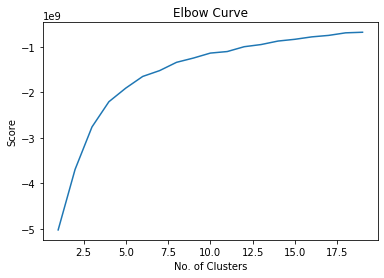

In [102]:
clus=range(1,20)
kmeans = [KMeans(n_clusters=i) for i in clus]
kmeans
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]
score
plt.plot(clus,score)
plt.xlabel('No. of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

#### k=5 is where the elbow is visible and hence we use 5 clusters

In [103]:
k = 5

neigh_cluster = df_demo.drop('Neighborhood', 1)

# cluster using KMeans and fit the data
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans = kmeans.fit(df)

#Cluster labels for first 10 observations
kmeans.labels_[0:10]

array([3, 3, 0, 4, 1, 0, 1, 1, 1, 0])

#### Create a new dataframe having cluster number and top 10 venues for each neighborhood

In [104]:
# Adding clustering labels
ethn_sorted_areas.insert(0, 'Cluster_Labels', kmeans.labels_)

In [105]:
# Add latitude and longitude to all neighborhoods
merged_toronto = df_can_urban.join(ethn_sorted_areas.set_index(['Neighborhood']), on=['Neighborhood'])

merged_toronto.head()

,CDN,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Ethnic Origin,2nd Most Common Ethnic Origin,3rd Most Common Ethnic Origin,4th Most Common Ethnic Origin,5th Most Common Ethnic Origin,6th Most Common Ethnic Origin,7th Most Common Ethnic Origin,8th Most Common Ethnic Origin,9th Most Common Ethnic Origin,10th Most Common Ethnic Origin
0,129,Agincourt North,43.80930,-79.26707,3,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,128,Agincourt South-Malvern West,43.78735,-79.26941,3,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
2,20,Alderwood,43.60496,-79.54116,0,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
3,95,Annex,43.66936,-79.40280,4,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French


#### Cluster Visualization

In [106]:
# create map
clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# Color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Adding markers to the map
colors_markers = []
for lat, lon, neigh, cluster in zip(merged_toronto['Latitude'], merged_toronto['Longitude'], merged_toronto['Neighborhood'], merged_toronto['Cluster_Labels']):
    label = folium.Popup(str(neigh) + ' - Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clusters_map)
       
clusters_map

### Cluster Study

#### Cluster 0

In [107]:
merged_toronto[merged_toronto['Cluster_Labels'] == 0].head(30)


,CDN,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Ethnic Origin,2nd Most Common Ethnic Origin,3rd Most Common Ethnic Origin,4th Most Common Ethnic Origin,5th Most Common Ethnic Origin,6th Most Common Ethnic Origin,7th Most Common Ethnic Origin,8th Most Common Ethnic Origin,9th Most Common Ethnic Origin,10th Most Common Ethnic Origin
2,20,Alderwood,43.604960,-79.541160,0,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
5,34,Bathurst Manor,43.763780,-79.454770,0,Filipino,Russian,Italian,Polish,Canadian,Jewish,Chinese,English,Ukrainian,Greek
9,39,Bedford Park-Nortown,43.730660,-79.424500,0,Canadian,Polish,English,Russian,Scottish,Irish,Filipino,Jewish,German,Italian
10,112,Beechborough-Greenbrook,43.693110,-79.478310,0,Portuguese,Jamaican,Italian,Canadian,Filipino,East Indian,English,Spanish,Vietnamese,Other African origins; n.i.e.
13,24,Black Creek,43.766360,-79.521500,0,Vietnamese,Jamaican,Canadian,Italian,East Indian,Chinese,Filipino,Iraqi,Ghanaian,Other African origins; n.i.e.
14,69,Blake-Jones,43.675220,-79.337620,0,English,Canadian,Irish,Scottish,Chinese,French,German,Greek,East Indian,Jamaican
15,108,Briar Hill-Belgravia,43.698520,-79.451250,0,Filipino,Italian,Portuguese,Canadian,English,Scottish,Irish,Albanian,Russian,Polish
16,41,Bridle Path-Sunnybrook-York Mills,43.727320,-79.380870,0,English,Scottish,Canadian,Chinese,Irish,Italian,German,French,Russian,Polish
17,57,Broadview North,43.689370,-79.354290,0,English,Irish,Scottish,Greek,Canadian,French,German,Chinese,Filipino,Serbian
18,30,Brookhaven-Amesbury,43.700310,-79.484650,0,Italian,Portuguese,Jamaican,Canadian,Filipino,Vietnamese,Chinese,Other African origins; n.i.e.,English,East Indian


#### Cluster 0 has people of European (English, Portugese, Italian, Polish ) and Canadian ethnic people. They are located mostly in the central and southern parts of Toronto City

#### Cluster 1

In [108]:
merged_toronto[merged_toronto['Cluster_Labels'] == 1].head(30)


,CDN,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Ethnic Origin,2nd Most Common Ethnic Origin,3rd Most Common Ethnic Origin,4th Most Common Ethnic Origin,5th Most Common Ethnic Origin,6th Most Common Ethnic Origin,7th Most Common Ethnic Origin,8th Most Common Ethnic Origin,9th Most Common Ethnic Origin,10th Most Common Ethnic Origin
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French
6,76,Bay Street Corridor,43.65771,-79.38618,1,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian
7,52,Bayview Village,43.77710,-79.37957,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish
8,49,Bayview Woods-Steeles,43.79485,-79.38222,1,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian
11,127,Bendale,43.75963,-79.25739,1,Chinese,East Indian,Filipino,Canadian,English,Scottish,Irish,Sri Lankan,Greek,French
30,47,Don Valley Village,43.78552,-79.35017,1,Chinese,Filipino,East Indian,Iranian,English,Canadian,Irish,Scottish,Korean,Armenian
31,126,Dorset Park,43.75533,-79.27746,1,Filipino,East Indian,Chinese,Canadian,Sri Lankan,English,Jamaican,Scottish,Tamil,Irish
48,53,Henry Farm,43.77229,-79.34086,1,Chinese,East Indian,Filipino,Iranian,Canadian,English,Scottish,Irish,Afghan,Korean
52,48,Hillcrest Village,43.80303,-79.35346,1,Chinese,East Indian,Canadian,Iranian,Korean,English,Russian,Scottish,Polish,Irish
62,78,Kensington-Chinatown,43.65331,-79.39634,1,Chinese,Canadian,English,Irish,Scottish,French,German,Italian,Polish,East Indian


#### Cluster 1 is densely populated by people of Chinese and Filipino ethnicity. These people are living in the northern and north eastern parts of Toronto city.

#### Cluster 2

In [109]:
merged_toronto[merged_toronto['Cluster_Labels'] == 2].head(30)


,CDN,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Ethnic Origin,2nd Most Common Ethnic Origin,3rd Most Common Ethnic Origin,4th Most Common Ethnic Origin,5th Most Common Ethnic Origin,6th Most Common Ethnic Origin,7th Most Common Ethnic Origin,8th Most Common Ethnic Origin,9th Most Common Ethnic Origin,10th Most Common Ethnic Origin
73,132,Malvern,43.81024,-79.22034,2,East Indian,Sri Lankan,Filipino,Chinese,Jamaican,Canadian,English,Tamil,Guyanese,Pakistani
81,2,Mount Olive-Silverstone-Jamestown,43.74721,-79.58826,2,East Indian,Iraqi,Jamaican,Canadian,Somali,Italian,Assyrian,Sri Lankan,Other African origins; n.i.e.,Ghanaian
105,131,Rouge,43.80766,-79.17405,2,East Indian,Sri Lankan,Canadian,Filipino,Jamaican,English,Chinese,Tamil,Scottish,Irish
124,1,West Humber-Clairville,43.71455,-79.59258,2,East Indian,Jamaican,Canadian,Filipino,Italian,Punjabi,English,Guyanese,Chinese,Scottish
132,137,Woburn,43.76748,-79.22829,2,East Indian,Canadian,Sri Lankan,Chinese,Filipino,English,Irish,Scottish,Jamaican,Tamil


#### Cluster 2 is primarily inhabited by people moved in to Canada from India. They are residing in the outskirts of Toronto city and indicated by sky blue color on the map

#### Cluster 3

In [110]:
merged_toronto[merged_toronto['Cluster_Labels'] == 3].head(30)


,CDN,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Ethnic Origin,2nd Most Common Ethnic Origin,3rd Most Common Ethnic Origin,4th Most Common Ethnic Origin,5th Most Common Ethnic Origin,6th Most Common Ethnic Origin,7th Most Common Ethnic Origin,8th Most Common Ethnic Origin,9th Most Common Ethnic Origin,10th Most Common Ethnic Origin
0,129,Agincourt North,43.80930,-79.26707,3,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,128,Agincourt South-Malvern West,43.78735,-79.26941,3,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
66,117,L'Amoreaux,43.79726,-79.31220,3,Chinese,East Indian,Canadian,Sri Lankan,Filipino,English,Armenian,Jamaican,Scottish,Irish
76,130,Milliken,43.82280,-79.27694,3,Chinese,Sri Lankan,East Indian,Filipino,Canadian,Tamil,Jamaican,English,Vietnamese,Spanish
112,116,Steeles,43.81221,-79.32132,3,Chinese,East Indian,Canadian,Filipino,English,Greek,Italian,Scottish,Sri Lankan,Egyptian
129,51,Willowdale East,43.77249,-79.40041,3,Chinese,Iranian,Korean,East Indian,English,Canadian,Scottish,Irish,Russian,Italian


#### Cluster 3 is dominated by people Chinese ethnic background. They are residing in the northern and north eastern parts, towards the outskirts of Toronto city and represented by flourescent green color on the map 

#### Cluster 4

In [111]:
merged_toronto[merged_toronto['Cluster_Labels'] == 4].head(30)


,CDN,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Ethnic Origin,2nd Most Common Ethnic Origin,3rd Most Common Ethnic Origin,4th Most Common Ethnic Origin,5th Most Common Ethnic Origin,6th Most Common Ethnic Origin,7th Most Common Ethnic Origin,8th Most Common Ethnic Origin,9th Most Common Ethnic Origin,10th Most Common Ethnic Origin
3,95,Annex,43.66936,-79.40280,4,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
12,122,Birchcliffe-Cliffside,43.69472,-79.26460,4,English,Irish,Canadian,Scottish,French,German,Chinese,Italian,Filipino,British Isles origins; n.i.e.
23,75,Church-Yonge Corridor,43.66024,-79.37868,4,English,Irish,Scottish,Chinese,Canadian,French,German,East Indian,Italian,Polish
32,93,Dovercourt-Wallace Emerson-Junction,43.66604,-79.43687,4,Portuguese,English,Canadian,Irish,Scottish,Chinese,Italian,German,French,East Indian
35,62,East End-Danforth,43.68415,-79.29911,4,English,Irish,Scottish,Canadian,French,German,Chinese,Italian,Polish,British Isles origins; n.i.e.
49,88,High Park North,43.65767,-79.46458,4,English,Irish,Scottish,Canadian,German,Polish,French,Ukrainian,Italian,Russian
50,87,High Park-Swansea,43.64704,-79.47114,4,English,Irish,Scottish,Canadian,German,Polish,French,Italian,Ukrainian,British Isles origins; n.i.e.
58,14,Islington-City Centre West,43.63608,-79.54296,4,English,Canadian,Italian,Irish,Scottish,Polish,Ukrainian,East Indian,German,Chinese
68,105,Lawrence Park North,43.72830,-79.40642,4,English,Scottish,Canadian,Irish,German,Chinese,French,Polish,Italian,Russian
69,103,Lawrence Park South,43.71852,-79.40576,4,English,Scottish,Canadian,Irish,German,Polish,Russian,French,Italian,Chinese


#### Cluster 4 is predominantly inhabited by English,Canadian and Portugese origin people.There are also Chinese, Scottish and Irish people residing in this cluster. This is represented by orange color on the map and present in the southern and central parts of Toronto City

### 5. Application of Clustering to find the ideal place to open a restaurant of a particular cuisine

#### Function to retrive venues from Foursquare API for the neighborhoods

In [112]:
def getNearbyVenues(cdn, latitudes, longitudes):
    
    venues_list=[]
    # Loop through each neighbourhood given in parameters
    for cdn, lat, lng in zip(cdn, latitudes, longitudes):

        # create the API request URL to explore the neighbourhood using FoursquareAPI
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venues 
        venues_list.append([(
            cdn,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # add the venues in the dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                        'CDN',
                        'Area Latitude', 
                        'Area Longitude', 
                        'Venue', 
                        'Venue Latitude', 
                        'Venue Longitude', 
                        'Venue Category'
    ]
    
    return(nearby_venues)

#### Ideal location to open a Chinese eatery

In [113]:
#Merge Clusters 1 and 3 as Chinese origin people are dwelling in both these clusters
chinese_toronto = merged_toronto[(merged_toronto['Cluster_Labels'] == 3) | (merged_toronto['Cluster_Labels'] == 1)]

chinese_toronto.head()

,CDN,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Ethnic Origin,2nd Most Common Ethnic Origin,3rd Most Common Ethnic Origin,4th Most Common Ethnic Origin,5th Most Common Ethnic Origin,6th Most Common Ethnic Origin,7th Most Common Ethnic Origin,8th Most Common Ethnic Origin,9th Most Common Ethnic Origin,10th Most Common Ethnic Origin
0,129,Agincourt North,43.80930,-79.26707,3,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,128,Agincourt South-Malvern West,43.78735,-79.26941,3,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French
6,76,Bay Street Corridor,43.65771,-79.38618,1,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian
7,52,Bayview Village,43.77710,-79.37957,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish


#### Obtain the already present Chinese restaurants in these locations using Foursquare API

In [114]:
# Retrieve the venues for all neighbourhoods
chinese_dining = getNearbyVenues(  
                                    cdn=chinese_toronto['CDN'],
                                    latitudes=chinese_toronto['Latitude'],
                                    longitudes=chinese_toronto['Longitude']
                                  )

chinese_dining[(chinese_dining['Venue Category'] == "Chinese Restaurant")].head()

,CDN,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,129,43.80930,-79.26707,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant
27,129,43.80930,-79.26707,Kin Kin Bubble Tea Co,43.807852,-79.270296,Chinese Restaurant
31,128,43.78735,-79.26941,Congee Me 小米粥鋪,43.787392,-79.268387,Chinese Restaurant
32,128,43.78735,-79.26941,Asian Legend 味香村,43.788068,-79.266768,Chinese Restaurant
37,128,43.78735,-79.26941,Perfect Chinese Restaurant 雅瓊海鮮酒家,43.787774,-79.270294,Chinese Restaurant


In [115]:
chinese_count = chinese_dining.groupby(['CDN','Area Latitude', 'Area Longitude']).count().reset_index()

# Drop unwanted columns
chinese_count = chinese_count.drop(chinese_count.columns[[1,2,3,4,5]],axis=1)
chinese_count.columns=['CDN', 'Count']

# merge the counts with chinese_toronto dataframe
chinese_toronto = chinese_toronto.join(chinese_count.set_index(['CDN']), on=['CDN'])
chinese_toronto = chinese_toronto.sort_values(by='Count')

chinese_toronto.head(20)

,CDN,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Ethnic Origin,2nd Most Common Ethnic Origin,3rd Most Common Ethnic Origin,4th Most Common Ethnic Origin,5th Most Common Ethnic Origin,6th Most Common Ethnic Origin,7th Most Common Ethnic Origin,8th Most Common Ethnic Origin,9th Most Common Ethnic Origin,10th Most Common Ethnic Origin,Count
111,40,St.Andrew-Windfields,43.75720,-79.38188,1,Chinese,English,Canadian,Iranian,Polish,Irish,Scottish,Russian,East Indian,Korean,1.0
130,37,Willowdale West,43.77094,-79.42785,1,Chinese,Korean,Iranian,English,Canadian,Irish,Scottish,Russian,Italian,East Indian,2.0
129,51,Willowdale East,43.77249,-79.40041,3,Chinese,Iranian,Korean,East Indian,English,Canadian,Scottish,Irish,Russian,Italian,2.0
8,49,Bayview Woods-Steeles,43.79485,-79.38222,1,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian,2.0
52,48,Hillcrest Village,43.80303,-79.35346,1,Chinese,East Indian,Canadian,Iranian,Korean,English,Russian,Scottish,Polish,Irish,3.0
11,127,Bendale,43.75963,-79.25739,1,Chinese,East Indian,Filipino,Canadian,English,Scottish,Irish,Sri Lankan,Greek,French,4.0
66,117,L'Amoreaux,43.79726,-79.31220,3,Chinese,East Indian,Canadian,Sri Lankan,Filipino,English,Armenian,Jamaican,Scottish,Irish,4.0
85,50,Newtonbrook East,43.79304,-79.40695,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,Italian,East Indian,Filipino,4.0
7,52,Bayview Village,43.77710,-79.37957,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish,4.0
48,53,Henry Farm,43.77229,-79.34086,1,Chinese,East Indian,Filipino,Iranian,Canadian,English,Scottish,Irish,Afghan,Korean,6.0


In [116]:
top_chinese = chinese_toronto.head(10)

# create map of Toronto using latitude and longitude values
chinese_map = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, CDN, neighborhood in zip(top_chinese['Latitude'], top_chinese['Longitude'], top_chinese['CDN'], top_chinese['Neighborhood']):
    label = '{} - {}'.format(CDN, neighborhood)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(chinese_map) 
    
chinese_map

#### From the table above we can see that the best locations. These locations have concentration Chinese origin people and least number of chinese restaurants as competition. Some of the most ideal places are St.Andrew-Windfields, Willodale West and East,  Bayview Woods-Steeles in that order. They can be seen on the map above in dark blue color.

#### As a continuation of the above analysis we can also look at the income and spending trends of people to determine what kind of restaurants can be opened in each of the neighborhoods 